In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, ZeroPadding2D, Input, MaxPool2D, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2024-04-23 04:34:30.897133: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 04:34:31.148085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
torch.cuda.is_available()

Num GPUs Available:  8


True

In [5]:
TRAINING_DIR = '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/train/'
VALIDATION_DIR = '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/valid/'
TESTING_DIR = '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/test/'
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224)
SEED = 777
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [6]:
tf.random.set_seed(SEED)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 84635 images belonging to 525 classes.
Batch index: 519


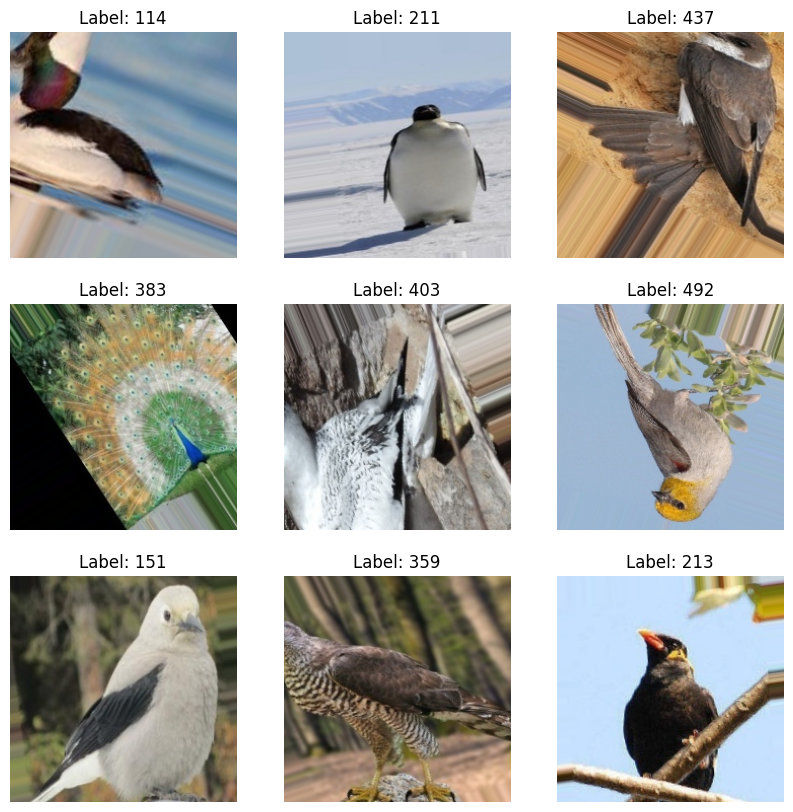

In [7]:
training_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    rotation_range=40
)
training_set = training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)
validation_gen = ImageDataGenerator(rescale=1./255)
validation_set = validation_gen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)

testing_gen = ImageDataGenerator(rescale=1./255)
testing_set = testing_gen.flow_from_directory(
    TESTING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)
# Generating images
generated_images = next(training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=9,
    target_size=INPUT_SHAPE,
    class_mode=None,
    shuffle=False
))

def decode_one_hot(labels):
    return [label.argmax() for label in labels]

# Choose a random batch index from the dataset
batch_index = random.randint(0, len(training_set) - 1)
print("Batch index:", batch_index)

# Retrieve the batch of images and labels
random_images, random_labels = training_set[batch_index]

# Decode the one-hot encoded labels
random_labels = decode_one_hot(random_labels)

# Limit the number of images to display to 9
num_images_to_display = min(len(random_images), 9)

# Display the random images with their corresponding class labels
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Label: {random_labels[i]}")
    plt.axis("off")
plt.show()

In [8]:
class LearningRateDecay(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        if epoch < 25 and epoch % 2 == 0:
            return
        else:
            self.model.optimizer.learning_rate = self.model.optimizer.learning_rate * tf.math.exp(-0.1)

class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['val_accuracy'] > 0.95:
            self.model.stop_training = True
            print('Early Stopping !, learning rate now is {}'.format(self.model.optimizer.learning_rate))

In [9]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.filters = filters
        self.bn = BatchNormalization()
        self.activation = ReLU()
        self.Conv_1 = Conv2D(filters, 1)
        self.Conv_3 = Conv2D(filters, 3, padding='same')

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.activation(x)
        x = self.Conv_1(x)
        x = self.Conv_3(x)
        return x


class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DenseBlock, self).__init__()
        self.conv_block = ConvBlock(filters)
        self.cont = Concatenate(axis=-1)

    def call(self, x, num_conv_block):
        inputs = [x]
        inputs.append(self.conv_block(x))
        for i in range(num_conv_block - 1):
            x = self.cont(inputs)
            x = self.conv_block(x)
            inputs.append(x)

        x = self.cont(inputs)
        return x


class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(TransitionBlock, self).__init__()
        self.bn = BatchNormalization()
        self.activation = ReLU()
        self.conv_1 = Conv2D(filters, 1)
        self.avgpooling = AveragePooling2D(pool_size=2, strides=2)

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.activation(x)
        x = self.conv_1(x)
        x = self.avgpooling(x)
        return x


class DenseNet(tf.keras.Model):
    def __init__(self, grow_rate, base_dims, num_classes, input_shape):
        super(DenseNet, self).__init__()
        self.conv_7 = Conv2D(base_dims, kernel_size=7,
                             strides=2, padding='same')
        num_conv_blocks = [6, 12, 24, 16]  
        self.conv_blocks = [ConvBlock(filters=base_dims + i * grow_rate)
                            for _ in range(4)]

        self.dense_blocks = [DenseBlock(
            base_dims + i * grow_rate) for i in range(4)]
        self.transition_blocks = [TransitionBlock(
            base_dims + i * grow_rate) for i in range(3)]
        self.glob_avg_pool = GlobalAveragePooling2D()
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv_7(inputs)
        # Loop through dense blocks and transition blocks
        for i, dense_block in enumerate(self.dense_blocks):
            # Assuming DenseBlock is now correctly initialized and doesn't require num_conv_blocks at call time
            x = dense_block(x, num_conv_block = 4)
            # No transition block after the last dense block
            if i < len(self.transition_blocks):
                x = self.transition_blocks[i](x)
        x = self.glob_avg_pool(x)
        return self.classifier(x)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121


def build_densenet_model(num_classes):
    # Load the DenseNet121 model, pre-trained on ImageNet data, excluding the top (classification) layer.
    base_model = DenseNet121(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freeze the layers of the base model to not train them again
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of DenseNet for our specific task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
    # Add a fully-connected layer with softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


# Example usage
num_classes = 525 # Change this to the number of classes in your dataset
model = build_densenet_model(num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

2024-04-23 04:35:43.159062: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-23 04:35:43.159491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23473 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-04-23 04:35:43.160100: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-23 04:35:43.179893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22107 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-04-23 04:35:43.180515: 

In [11]:
history = model.fit(
    training_set,
    # steps_per_epoch=len(training_set),
    epochs=10,  
    validation_data=validation_set,
    # validation_steps=int(0.25*len(validation_set))
)


Epoch 1/10


/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713846962.226990 3888490 service.cc:145] XLA service 0x7f96740822f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713846962.227077 3888490 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1713846962.227090 3888490 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1713846962.227096 3888490 service.cc:153]   StreamExecutor device (2): NVIDIA RTX 6000 Ada Generation, Compute Cap

   1/5290 ━━━━━━━━━━━━━━━━━━━━ 35:51:27 24s/step - accuracy: 0.0000e+00 - loss: 6.4286

I0000 00:00:1713846973.526766 3888490 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  99/5290 ━━━━━━━━━━━━━━━━━━━━ 22:07 256ms/step - accuracy: 0.0028 - loss: 7.5752

In [ ]:
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [ ]:
#lrs = [0.00001]
lr = 0.0001
#for lr in lrs :
   
model = DenseNet(GROW_RATE, base_dims=BASE_FILTERS,
                 num_classes=NUM_CLASSES, input_shape=IMAGES_SHAPE)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics=['accuracy'])
print("Model Compliled")
history = model.fit(training_set,
        # steps_per_epoch = len(training_set),
        epochs=2,
        # batch_size=16,
        validation_data =validation_set,
        # validation_steps = int(0.25*len(validation_set))
        )
model.evaluate(testing_set)
# Plot the training and validation accuracy and loss


Model Compliled
Epoch 1/2


TypeError: Exception encountered when calling DenseNet.call().

[1mmissing a required argument: 'num_conv_block'[0m

Arguments received by DenseNet.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined